# import & read_data 

## 사용 쿼리 
http://redash.idus.io/queries/3652/source


```sql
with
user_info as (
    select user_id
        , signup_date
        , first_buy_date
        , last_buy_date
    from s_data.user_purchase_info
    where last_buy_date between date'2020-06-01' and date'2021-05-31'
),
user_info2 as (
    select b.*
        , count(distinct a.ordernum) as cnt_order
        , sum(try_cast(a.pay_total_price as decimal)) as price_order
    from bk_idusme.order_total a
        join user_info b on a.user_id = b.user_id
    where a.lastest_state NOT IN (4, 10) -- 주문/결제결과 이상 없는 건 only
    	and a.user_id not in (20) -- 아이디어스 계정 제외
    	and a.artist_id not in (1919927) -- 작가스토어 제외
        and a.created between date'2020-06-01' and date'2021-05-31'
    group by 1, 2, 3, 4
),
category as (
    select concat(lpad(cast(c_sortidx as varchar), 2, '0'), '_', c_name) as category_name 
        , uuid as value 
    from bk_idusme.product_category
    where is_visible = true 
    order by c_sortidx 
),
last_ordernum as (
    select a.user_id, max_by(b.ordernum, b.id) as last_ordernum
    from user_info a
    join bk_idusme.order_total b on a.user_id = b.user_id
    where b.lastest_state NOT IN (4, 10) -- 주문/결제결과 이상 없는 건 only
    	and b.user_id not in (20) -- 아이디어스 계정 제외
    	and b.artist_id not in (1919927) -- 작가스토어 제외
    group by 1
)
select d.*
    , a.user_vip_state
    , a.product_name
    , c.category_grp 
    , b.category_name
    , a.artist_name
    , a.pay_total_price
from bk_idusme.order_total a  -- pk 는 order_id 
left join category b on a.product_category_uuid = b.value 
left join s_data.category_group c on a.product_category_uuid = c.category_uuid
left join user_info2 d on a.user_id = d.user_id
where a.ordernum in (select last_ordernum from last_ordernum) 
    and a.lastest_state NOT IN (4, 10) -- 주문/결제결과 이상 없는 건 only
	and a.user_id not in (20) -- 아이디어스 계정 제외
	and a.artist_id not in (1919927) -- 작가스토어 제외
```

## import library 

In [37]:
# 분석을 위한 library를 import 합니다.
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
plt.rc('font',family = 'AppleGothic') ## 한글 폰트 사용하기

### define funtion 

In [9]:
def iqr( x ) :
    Q3 = np.percentile(x, 75)
    Q1= np.percentile(x, 25)
    Q2 = np.percentile(x, 50)
    IQR = Q3-Q1
    min_iqr = Q1-IQR*1.5
    max_iqr = Q3 +IQR*1.5
    return(min_iqr, max_iqr)

In [10]:
def ecdf(data) :
    n = len(data) 
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    return x,y

## read_csv

In [11]:
# 최초 파일 로드할때만 돌리세요

df = pd.read_csv ('3652.tsv' 
, sep = '\t' #tsv 인 경우
, header = None # 헤더 없는 경우
)   

In [12]:
df.rename(columns = {0:'user_id', 1 :'signup_date', 2: 'first_buy_date',\
    3 : 'last_buy_date', 4: 'cnt_order', 5:'price_order', 6:'user_vip_state',\
    7 :'product_name', 8 : 'category_grp', 9 : 'category_name',\
    10: 'artist_name', 11:'pay_total_price'}
, inplace =True)

In [13]:
# df.set_index('index', inplace=True)''

In [14]:
df.columns

Index(['user_id', 'signup_date', 'first_buy_date', 'last_buy_date',
       'cnt_order', 'price_order', 'user_vip_state', 'product_name',
       'category_grp', 'category_name', 'artist_name', 'pay_total_price'],
      dtype='object')

In [15]:
df.index

RangeIndex(start=0, stop=1449209, step=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449209 entries, 0 to 1449208
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   user_id          1449209 non-null  int64  
 1   signup_date      1449209 non-null  object 
 2   first_buy_date   1449209 non-null  object 
 3   last_buy_date    1449209 non-null  object 
 4   cnt_order        1449209 non-null  int64  
 5   price_order      1449209 non-null  int64  
 6   user_vip_state   1449209 non-null  int64  
 7   product_name     1449207 non-null  object 
 8   category_grp     1449206 non-null  object 
 9   category_name    1449094 non-null  object 
 10  artist_name      1449206 non-null  object 
 11  pay_total_price  1449208 non-null  float64
dtypes: float64(1), int64(4), object(7)
memory usage: 132.7+ MB


In [17]:
df['user_id'].value_counts()
# cmd + i -> suggest

5957543    49
4769004    39
3766212    27
641789     23
5818355    23
           ..
7448614     1
7471633     1
539322      1
6828992     1
4079438     1
Name: user_id, Length: 1208046, dtype: int64

In [18]:
df.head(4)

user_id              signup_date           first_buy_date  \
0  7126048  2021-02-12 12:47:53.000  2021-02-12 13:13:06.000   
1  7126048  2021-02-12 12:47:53.000  2021-02-12 13:13:06.000   
2  1699786  2017-12-18 18:07:44.000  2019-07-15 23:57:25.000   
3  5140388  2020-03-17 08:19:44.000  2021-02-11 20:57:30.000   

             last_buy_date  cnt_order  price_order  user_vip_state  \
0  2021-02-12 13:13:07.000          1        59000               0   
1  2021-02-12 13:13:07.000          1        59000               0   
2  2021-02-12 16:35:33.000          2       169500               0   
3  2021-02-12 18:15:13.000          3        39300               0   

                   product_name category_grp    category_name  \
0             단디 핑크핑크 세트 딸치딸롤세트        1. 식품  01_디저트, 베이커리, 떡   
1               디저트단디 프로마쥬 3종세트        1. 식품  01_디저트, 베이커리, 떡   
2                    정민서님 개인 결제      4. 홈/리빙            37_기타   
3  2월특가무배6900 All써지컬 2월 탄생석 목걸이      3. 액세서리           18_목걸이   

       artist_name  pay_total_price  
0            디저트단디          23000.0  
1            디저트단디          36000.0  
2        유니크한복 심쿵사          29000.0  
3  목걸이맛집 구루미 9rumi           6900.0

# EDA

## table values 

* 

In [19]:
df['category_grp'].value_counts()

4. 홈/리빙       398141
1. 식품         355720
5. 디지털/문구     238689
3. 액세서리       228891
2. 패션/패션잡화    193026
6. 화장품/미용      34738
13900.0000         1
Name: category_grp, dtype: int64

In [20]:
# 중복건
# order lv. 에서 unique 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449209 entries, 0 to 1449208
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   user_id          1449209 non-null  int64  
 1   signup_date      1449209 non-null  object 
 2   first_buy_date   1449209 non-null  object 
 3   last_buy_date    1449209 non-null  object 
 4   cnt_order        1449209 non-null  int64  
 5   price_order      1449209 non-null  int64  
 6   user_vip_state   1449209 non-null  int64  
 7   product_name     1449207 non-null  object 
 8   category_grp     1449206 non-null  object 
 9   category_name    1449094 non-null  object 
 10  artist_name      1449206 non-null  object 
 11  pay_total_price  1449208 non-null  float64
dtypes: float64(1), int64(4), object(7)
memory usage: 132.7+ MB


In [22]:
# df_order_dist = pd.DataFrame(df.groupby ( by = 'cnt_order' )['user_id'].count()).rename(columns = {'order_cnt':'cnt'})

In [23]:
# df_order_dist[:10]['user_id'].plot( kind ='bar')

In [24]:
# df_orderPrice_dist = pd.DataFrame(df.groupby ( by = 'cnt_order' )['price_order'].sum()).rename(columns = {'order_cnt':'cnt'})/10000

## 대카테고리별 제품가격 분포

In [25]:

df_catPrice = df.pivot( columns = 'category_grp', values='pay_total_price')

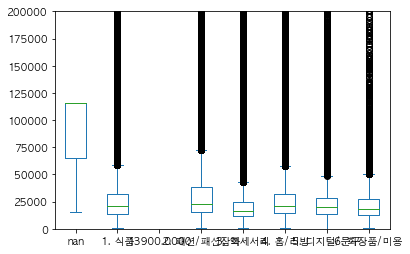

In [36]:
# # outlier 가 너무 많아 의미없는 시각화 

df_catPrice.plot( kind= 'box') 
plt.ylim( 0,200000)
plt.show()



In [27]:
# df_catPrice.iloc[:3][1]

In [28]:
df_catPrice.columns

Index([         nan,      '1. 식품', '13900.0000', '2. 패션/패션잡화',    '3. 액세서리',
          '4. 홈/리빙',  '5. 디지털/문구',  '6. 화장품/미용'],
      dtype='object', name='category_grp')

In [29]:
df_food = df_catPrice['1. 식품'].dropna()
df_hl = df_catPrice['2. 패션/패션잡화'].dropna()

In [30]:
x , y = ecdf(df_food)
x_hl , y_hl = ecdf(df_hl)

(0.0, 200000.0)

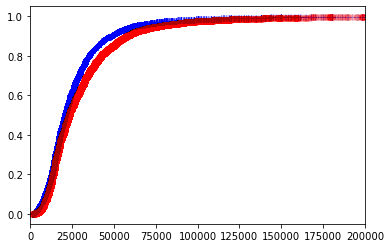

In [31]:

plt.plot( x,y, marker = '+', alpha = .01  , color = 'b')
plt.plot( x_hl  , y_hl, marker = 'o' ,  alpha = .01, color = 'r' )
plt.xlim (0, 200000)
# plt.figure ( )

In [32]:
# df .head(100)
